In [1]:
import pandas as pd
import os
from matplotlib import pylab as plt
import numpy as np
from pyteomics import mzml, fasta, parser
from matplotlib_venn import venn2, venn3
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

In [2]:
dot_size = 10
font_on_figure = 8
plt.rcParams.update({'mathtext.default':  'regular' })

In [3]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

def set_cov_factor(gaus_kde, x_range):
    gaus_kde.covariance_factor = lambda : .25
    gaus_kde._compute_covariance()
    return gaus_kde(x_range)

In [4]:
def get_quant_df(path, fdr=1, lvl="ms1"):
    df = pd.read_table(path)
    if fdr != 1:
        df = df[df["PG.Qvalue"] <  fdr / 100] 
    df.index = df["PG.ProteinGroups"].apply(lambda x: x.split(";")[0])
    cols =  [x for x in df.columns if "PG.Quantity" in x]
    hit_cols = [x for x in df.columns if "IsSingleHit" in x]
    if lvl == "ms2":
        cols = [x for x in df.columns if "PG.MS2Quantity" in x]
    df_slice = df.loc[:, cols + hit_cols]
    return df_slice

In [5]:
yeast_prot = []
with fasta.read("/groups/protechhub/user/JuliaBubis/projects/7_Astral_paper/fasta/JB_yeast_SP_20231211.fasta") as f:
    for n, s in f:
        yeast_prot.append(n.split("|")[1])

## Loading and saving data

### Exploris data

In [7]:
 names_dict = {"200pg_50pg_H_Y":"H200_Y50",
              "150pg_100pg_H_Y":"H150_Y100",
              "240pg_10pg_H_Y":"H240_Y10",
              "150pgH_100pgY": "H150_Y100",
              "240pgH_10pgY":"H240_Y10",
              "200pgH_50pgY":"H200_Y50"}
def get_col_name(s):
    first =  "_".join(s.split(".")[0].split("_")[7:])
    first = first.replace( first[:-3], names_dict[first[:-3]])
    first = first.replace("_0", "_r")
    last = s.split(".")[-1]
    if last == "MS2Quantity":
        last = "Quantity"
    return "_".join([first, last])   

In [8]:
paths = [
"/groups/protechhub/user/Manuel/PRIDE/21_AstralPaper/2Proteome-Exploris/20240112_124711_MM_AErun01_150H_100Y_MBR/MM_AErun01_150H_100Y_MBR_Report_Protein_JB (Pivot).tsv",
"/groups/protechhub/user/Manuel/PRIDE/21_AstralPaper/2Proteome-Exploris/20240112_124537_MM_AErun01_240H_10Y_MBR/MM_AErun01_240H_10Y_MBR_Report_Protein_JB (Pivot).tsv",
"/groups/protechhub/user/Manuel/PRIDE/21_AstralPaper/2Proteome-Exploris/20240112_124627_MM_AErun01_200H_50Y_MBR/MM_AErun01_200H_50Y_MBR_Report_Protein_JB (Pivot).tsv"]

In [19]:
raws = []
for root, folders, files in os.walk("/groups/protechhub/user/Manuel/PRIDE/21_AstralPaper/2Proteome-Astral/"):
    r = [x for x in files if x.endswith(".sne")]
    raws += r
for i in sorted(list(set(raws))):
    print(i)

20240209_104720_JB_human150yeast100_240k_20Th_40ms_50SPD_MBR.sne
20240209_104829_JB_human200yeast50_240k_20Th_40ms_50SPD_MBR.sne
20240209_104914_JB_human240yeast10_240k_20Th_40ms_50SPD_MBR.sne


In [9]:
hy_quant_cols = []
for path in paths[:]:
    hy_quant_cols.append(get_quant_df(path))
hy_quant_data = pd.concat(hy_quant_cols, axis = 1)
cols_name_dict = dict([(x, get_col_name(x)) for x in hy_quant_data.columns])
hy_quant_data.rename(cols_name_dict, axis=1, inplace=True)
q = "Quantity"
singlehit =  "IsSingleHit"
for s in ["H200_Y50",  "H240_Y10",  "H150_Y100"]:
    qcols = ["_".join([s, "r" + r, q]) for r in "123"]
    singleHitcols = ["_".join([s, "r" + r, singlehit]) for r in "123"]
    hy_quant_data["_".join([s, "mean"])] = hy_quant_data.loc[:, qcols].dropna().mean(axis=1)
    hy_quant_data["_".join([s, singlehit])] = hy_quant_data.loc[:, singleHitcols].any(axis=1)
    hy_quant_data["_".join([s, "cv"])] = hy_quant_data.loc[:, qcols].std(axis=1) / hy_quant_data.loc[:, qcols].mean(axis=1)
hy_quant_data["PG"] = hy_quant_data.index
hy_quant_data["organism"] = hy_quant_data["PG"].apply(lambda x: "Yeast" if x.split(";")[0] in yeast_prot else "Human")

In [10]:
pairs = [("H150_Y100",  "H200_Y50"), ("H150_Y100", "H240_Y10"), ("H200_Y50", "H240_Y10")]
exploris_slice = dict()
for pair in pairs:
    cols = ["_".join([x, "mean"]) for x in pair] + ["_".join([x, "cv"]) for x in pair] + ["_".join([x, singlehit]) for x in pair]
    df = hy_quant_data.loc[hy_quant_data[~ hy_quant_data.index.str.startswith("cont_")].index, cols + ["organism"]]    
    df.dropna(inplace=True)
    df.to_csv("./serialized_data/fig3/" + "_".join(["f3", "exploris", "ms1"] + list(pair))+".csv", index=False)
    exploris_slice["_".join(list(pair))] = df.index

### Astral ms1

In [11]:
paths = [
"/groups/protechhub/user/Manuel/PRIDE/21_AstralPaper/2Proteome-Astral/20240209_104829_JB_human200yeast50_240k_20Th_40ms_50SPD_MBR/JB_human200yeast50_240k_20Th_40ms_50SPD_MBR_Report_Protein_JB (Pivot).tsv",
"/groups/protechhub/user/Manuel/PRIDE/21_AstralPaper/2Proteome-Astral/20240209_104720_JB_human150yeast100_240k_20Th_40ms_50SPD_MBR/JB_human150yeast100_240k_20Th_40ms_50SPD_MBR_Report_Protein_JB (Pivot).tsv",
 "/groups/protechhub/user/Manuel/PRIDE/21_AstralPaper/2Proteome-Astral/20240209_104914_JB_human240yeast10_240k_20Th_40ms_50SPD_MBR/JB_human240yeast10_240k_20Th_40ms_50SPD_MBR_Report_Protein_JB (Pivot).tsv"]

In [12]:
hy_quant_cols = []
for path in paths:
    hy_quant_cols.append(get_quant_df(path))
hy_quant_data = pd.concat(hy_quant_cols, axis = 1)
cols_name_dict = dict([(x, get_col_name(x)) for x in hy_quant_data.columns])
hy_quant_data.rename(cols_name_dict, axis=1, inplace=True)
q = "Quantity"
singlehit =  "IsSingleHit"
for s in ["H200_Y50",  "H240_Y10",  "H150_Y100"]:
    qcols = ["_".join([s, "r" + r, q]) for r in "123"]
    singleHitcols = ["_".join([s, "r" + r, singlehit]) for r in "123"]
    hy_quant_data["_".join([s, "mean"])] = hy_quant_data.loc[:, qcols].dropna().mean(axis=1)
    hy_quant_data["_".join([s, singlehit])] = hy_quant_data.loc[:, singleHitcols].any(axis=1)
    hy_quant_data["_".join([s, "cv"])] = hy_quant_data.loc[:, qcols].std(axis=1) / hy_quant_data.loc[:, qcols].mean(axis=1)
hy_quant_data["PG"] = hy_quant_data.index
hy_quant_data["organism"] = hy_quant_data["PG"].apply(lambda x: "Yeast" if x.split(";")[0] in yeast_prot else "Human")

In [13]:
pairs = [("H150_Y100",  "H200_Y50"), ("H150_Y100", "H240_Y10"), ("H200_Y50", "H240_Y10")]
for pair in pairs:
    cols = ["_".join([x, "mean"]) for x in pair] + ["_".join([x, "cv"]) for x in pair] + ["_".join([x, singlehit]) for x in pair]
    df = hy_quant_data.loc[hy_quant_data[~ hy_quant_data.index.str.startswith("cont_")].index, cols + ["organism"]]    
    print(pair)
    df.dropna(inplace=True)
    df.to_csv("./serialized_data/fig3/" + "_".join(["f3", "astral", "ms1"] + list(pair))+".csv", index=False)
    intersec_AE = set(exploris_slice["_".join(list(pair))]) & set(df.index)
    df_intersec = df.loc[list(intersec_AE), :]
    print("./serialized_data/" + "_".join(["f3", "astral_exploris_slice", "ms1"] + list(pair))+".csv")
    df_intersec.to_csv("./serialized_data/fig3/" + "_".join(["f3", "astral_exploris_slice", "ms1"] + list(pair))+".csv", index=False)

('H150_Y100', 'H200_Y50')
./serialized_data/f3_astral_exploris_slice_ms1_H150_Y100_H200_Y50.csv
('H150_Y100', 'H240_Y10')
./serialized_data/f3_astral_exploris_slice_ms1_H150_Y100_H240_Y10.csv
('H200_Y50', 'H240_Y10')
./serialized_data/f3_astral_exploris_slice_ms1_H200_Y50_H240_Y10.csv


## Load and plot figures (works w/o Spectronaut resuts)

### Panels

In [7]:
def plot_panelb(ax, df, pair):
    xs = np.linspace(ymin, ymax, 100)
    df["FC"] = np.log2(df["_".join([pair[0], "mean"])] /  df["_".join([pair[1], "mean"])])
    df["x"] = np.log2((df["_".join([pair[0], "mean"])] + df["_".join([pair[1], "mean"])]) / 2)
    h1, y1 = [int(x[1:]) for x in pair[0].split("_")]  
    h2, y2 = [int(x[1:]) for x in pair[1].split("_")]
    labels = [[h1, h2], [y1, y2]]
    for organ, color, l, line in zip(["Human", "Yeast"], colors, labels, [np.log2(h1 / h2), np.log2(y1 / y2)]):
        ax.scatter(df[df.organism == organ]["x"], df[df.organism == organ]["FC"], alpha = 1, c=color, s=0.2)
        ax.scatter([-10], [-10], c=color, label=f"{organ}({l[0]}/{l[1]})")
        ax.annotate(f'{organ} ({df[df.organism == organ].shape[0]})', xy=(12.5, line - 0.6),  ha='right', color="black")
        ax.hlines(line, 0, 20, linestyles = "dashed", color="black")
    ax.hlines(100, 0, 20, linestyles = "dashed", color="black", label="actual ratio")
    ax.set_ylabel("$log_{2}(FC)$")
    ax.set_xlabel("$log_{2}(Protein\ Abundance)$")
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.legend(loc=2)
    
def plot_panelc(ax2, df, pair):
    xs = np.linspace(ymin, ymax, 100)
    df["FC"] = np.log2(df["_".join([pair[0], "mean"])] /  df["_".join([pair[1], "mean"])])
    df["x"] = np.log2((df["_".join([pair[0], "mean"])] + df["_".join([pair[1], "mean"])]) / 2)
    h1, y1 = [int(x[1:]) for x in pair[0].split("_")]  
    h2, y2 = [int(x[1:]) for x in pair[1].split("_")]
    labels = [[h1, h2], [y1, y2]]
    for organ, color,l, line in zip(["Human", "Yeast"], colors, labels, [np.log2(h1 / h2), np.log2(y1 / y2)]):
        y1 = set_cov_factor(gaussian_kde(df[df.organism == organ]["FC"]), xs)
        y = df[df.organism == organ]["FC"]
        ax2.plot(y1, xs, c=color, label=f"{organ}, SD={np.std(y1):.2f}")
        ax2.hlines(xs[np.argmax(y1)], 0, 2, linestyles = "dashed", color=color)
        ax2.annotate(f"SD={np.std(y):.2f}", xy = (0.7, xs[np.argmax(y1)] + 0.3))
    ax2.set_xlabel("Density")
    ax2.set_xlim(0, 2)
    ax2.set_yticklabels([])
    ax2.set_ylim(ymin, ymax)
    
def plot_panela(ax1, df, pair, colors,  ymin=-4, ymax=5, xmin=6, xmax=18, ):
    xs = np.linspace(ymin, ymax, 100)
    df["FC"] = np.log2(df["_".join([pair[0], "mean"])] /  df["_".join([pair[1], "mean"])])
    df["x"] = np.log2((df["_".join([pair[0], "mean"])] + df["_".join([pair[1], "mean"])]) / 2)
    h1, y1 = [int(x[1:]) for x in pair[0].split("_")]  
    h2, y2 = [int(x[1:]) for x in pair[1].split("_")]
    x = df.sort_values("x", ascending=True)["x"][roll_win-1:]
    y = df.sort_values("x", ascending=True).rolling(window=roll_win, on ="x")["_".join([pair[0], "cv"])].mean().dropna() * 100
    print(pair[0], df.shape, len(y))
    popt, pcov = curve_fit(func, x, y, p0=(1, 2, 2), 
                       bounds=((0, 0, 0), (np.inf, np.inf, np.inf)),
                       sigma=1/y)
    ax1.scatter(x, y, color="grey", s=0.2,)
    ax1.scatter([-10], [-10], color='grey', label="experimental data")
    ax1.plot(x, func(x, *popt), color=colors[2], label ="fit")
    ax1.set_xticklabels([])
    ax1.set_ylabel("mean CV, %")
    ax1.set_ylim(0, 50)
    ax1.legend(loc=1)
    ax1.set_xlim(xmin, xmax)

### Figures plotting

In [8]:
colors = ["#008066", "#e05959", "#5f8dd3"]
pairs = [("H150_Y100",  "H200_Y50"), ("H150_Y100", "H240_Y10"), ("H200_Y50", "H240_Y10")]
ymin = -4
ymax = 5
xmin = 6 #1
xmax = 18 #13
roll_win = 100
xs = np.linspace(ymin, ymax, 100)
data_astral = dict()
data_intersec = dict()
data_exploris = dict()

for pair in pairs:
    motif = "_".join(pair)
    data_astral[motif] = pd.read_csv(f"./serialized_data/fig3/f3_astral_ms1_{motif}.csv")
    data_intersec[motif] = pd.read_csv(f"./serialized_data/fig3/f3_astral_exploris_slice_ms1_{motif}.csv")
    data_exploris[motif] = pd.read_csv(f"./serialized_data/fig3/f3_exploris_ms1_{motif}.csv")

### data astral

H150_Y100 (6565, 15) 6466
H150_Y100 (5673, 15) 5574
H200_Y50 (6112, 15) 6013


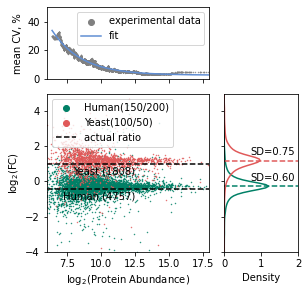

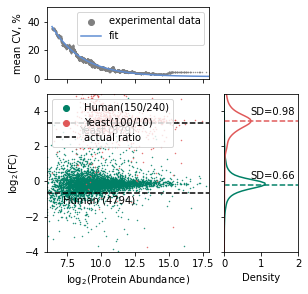

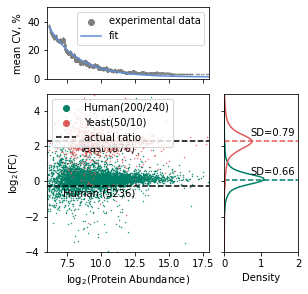

In [12]:
main_serialized_data = list()
main_cv_serialized_data = list()
for pair in pairs:
    df = data_astral["_".join(pair)]
    df["Astral_FC_" + "_".join(pair)] = np.log2(df["_".join([pair[0], "mean"])] /  df["_".join([pair[1], "mean"])])
    df["Astral_x_" + "_".join(pair)] = np.log2((df["_".join([pair[0], "mean"])] + df["_".join([pair[1], "mean"])]) / 2)
    main_serialized_data.append(df.loc[:, ["Astral_x_" + "_".join(pair), "Astral_FC_" + "_".join(pair), "organism"]])
    

    # df["x"] = np.log2((df["_".join([pair[0], "mean"])] + df["_".join([pair[1], "mean"])]) / 2)
    # x = df.sort_values("x", ascending=True)["x"][roll_win-1:]
    # y = df.sort_values("x", ascending=True).rolling(window=roll_win, on ="x")["_".join([pair[0], "cv"])].mean().dropna() * 100
    # main_cv_serialized_data.append(pd.DataFrame({"Astral_CVx_" + "_".join(pair): x.values,"Astral_CVy_" + "_".join(pair): y.values}))
    # break
    fig = plt.figure(figsize=(4.5, 4.5))
    gs = gridspec.GridSpec(3, 3)
    ax = plt.subplot(gs[1:3, :2])
    ax1 = plt.subplot(gs[0, :2])
    ax2 = plt.subplot(gs[1:3, 2])
    plot_panelb(ax, data_astral["_".join(pair)], pair)
    plot_panelc(ax2, data_astral["_".join(pair)], pair)
    plot_panela(ax1, data_astral["_".join(pair)], pair, colors=colors)

### data exploris

H150_Y100 (2419, 9) 2320
H150_Y100 (2211, 9) 2112
H200_Y50 (2315, 9) 2216


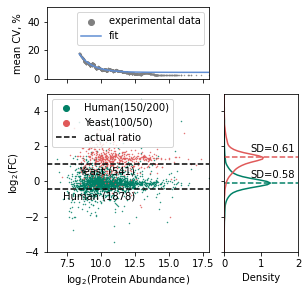

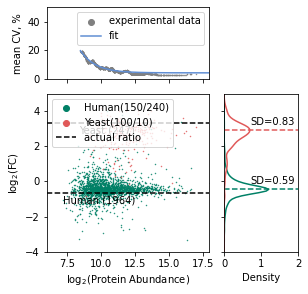

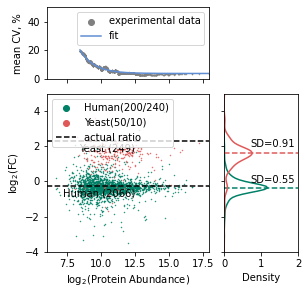

In [10]:
for pair in pairs:
    df = data_astral["_".join(pair)]
    df["Exploris_FC_" + "_".join(pair)] = np.log2(df["_".join([pair[0], "mean"])] /  df["_".join([pair[1], "mean"])])
    df["Exploris_x_" + "_".join(pair)] = np.log2((df["_".join([pair[0], "mean"])] + df["_".join([pair[1], "mean"])]) / 2)
    main_serialized_data.append(df.loc[:, ["Exploris_x_" + "_".join(pair), "Exploris_FC_" + "_".join(pair), "organism"]])
    
    # df["x"] = np.log2((df["_".join([pair[0], "mean"])] + df["_".join([pair[1], "mean"])]) / 2)
    # x = df.sort_values("x", ascending=True)["x"][roll_win-1:]
    # y = df.sort_values("x", ascending=True).rolling(window=roll_win, on ="x")["_".join([pair[0], "cv"])].mean().dropna() * 100
    # main_cv_serialized_data.append(pd.DataFrame({"Exploris_CVx_" + "_".join(pair): x.values,"Exploris_CVy_" + "_".join(pair): y.values}))
    
    fig = plt.figure(figsize=(4.5, 4.5))
    gs = gridspec.GridSpec(3, 3)
    ax = plt.subplot(gs[1:3, :2])
    ax1 = plt.subplot(gs[0, :2])
    ax2 = plt.subplot(gs[1:3, 2])
    plot_panelb(ax, data_exploris["_".join(pair)], pair)
    plot_panelc(ax2, data_exploris["_".join(pair)], pair)
    plot_panela(ax1, data_exploris["_".join(pair)], pair, colors=colors)

### data astral on exploris ids

H150_Y100 (2355, 9) 2256
H150_Y100 (2155, 9) 2056
H200_Y50 (2263, 9) 2164


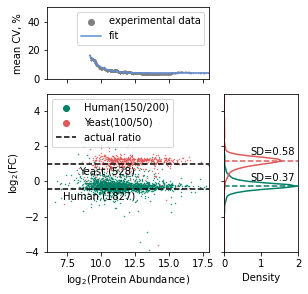

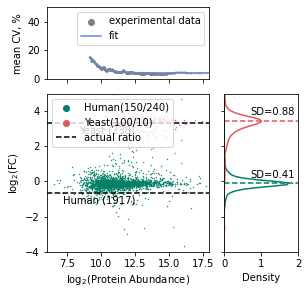

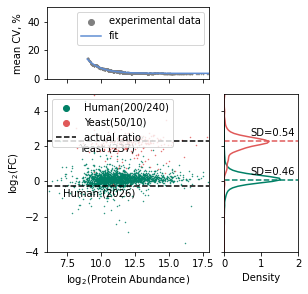

In [11]:
for pair in pairs:
    df = data_astral["_".join(pair)]
    df["Astral_on_intersection_FC_" + "_".join(pair)] = np.log2(df["_".join([pair[0], "mean"])] /  df["_".join([pair[1], "mean"])])
    df["Astral_on_intersection_x_" + "_".join(pair)] = np.log2((df["_".join([pair[0], "mean"])] + df["_".join([pair[1], "mean"])]) / 2)
    main_serialized_data.append(df.loc[:, ["Astral_on_intersection_x_" + "_".join(pair), "Astral_on_intersection_FC_" + "_".join(pair), "organism"]])
    
    # df['x'] = np.log2((df["_".join([pair[0], "mean"])] + df["_".join([pair[1], "mean"])]) / 2)
    # x = df.sort_values("x", ascending=True)["x"][roll_win-1:]
    # y = df.sort_values("x", ascending=True).rolling(window=roll_win, on ="x")["_".join([pair[0], "cv"])].mean().dropna() * 100
    # main_cv_serialized_data.append(pd.DataFrame({"Astral_on_intersection_CVx_" + "_".join(pair): x.values,"Astral_on_intersection_CVy_" + "_".join(pair): y.values}))
    
    fig = plt.figure(figsize=(4.5, 4.5))
    gs = gridspec.GridSpec(3, 3)
    ax = plt.subplot(gs[1:3, :2])
    ax1 = plt.subplot(gs[0, :2])
    ax2 = plt.subplot(gs[1:3, 2])
    plot_panelb(ax, data_intersec["_".join(pair)], pair)
    plot_panelc(ax2, data_intersec["_".join(pair)], pair)
    plot_panela(ax1, data_intersec["_".join(pair)], pair, colors=colors)

In [20]:
# pd.concat(main_serialized_data, axis=1).to_csv("serialized_data/main_f3.csv", sep='\t', index=False)
# pd.concat(main_cv_serialized_data, axis=1).to_csv("serialized_data/main_f3_cv.csv",  sep='\t', index=False)